In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Import training data
df = pd.read_csv("GSPC_Training_Dataset.csv")

# Print and check
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000
...,...,...,...,...,...,...,...
2510,2010-12-27,1254.660034,1258.430054,1251.479980,1257.540039,1257.540039,1992470000
2511,2010-12-28,1259.099976,1259.900024,1256.219971,1258.510010,1258.510010,2478450000
2512,2010-12-29,1258.780029,1262.599976,1258.780029,1259.780029,1259.780029,2214380000
2513,2010-12-30,1259.439941,1261.089966,1256.319946,1257.880005,1257.880005,1970720000


### **Preprocess the stock market data**

In [5]:
import math

# Prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# Returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
    lines = open("" + key + ".csv", "r").read().splitlines()

    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))

    return vec

# Returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Returns an an n-day state representation ending at time t
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array([res])

### **Build DQN agent**

In [6]:
# Import libraries
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2

class Agent:

    def __init__(self, state_size, is_eval=False, model_name=""):
        # Initializing hyper-parameters
        self.gamma = 0.95
        self.learning_rate = 0.001
        self.memory_size = 1000
        self.batch_size = 32
        self.exploration_max = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.exploration_rate = self.exploration_max
        self.state_size = state_size
        self.is_eval = is_eval
        self.inventory = []
        # Buy/Sell/Sit
        self.action_size = 3
        # Initialize Memory Object
        self.memory = deque(maxlen=self.memory_size)
        # Call or build model
        self.model = load_model(model_name) if is_eval else self._model()

    def _model(self):
        # build model architecture
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(self.state_size,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_size, activation="linear"))
        self.model.compile(loss="mse", optimizer=adam_v2.Adam(learning_rate=self.learning_rate))
        # Return model
        return self.model

    def act(self, state):
        #Logic for epsGreedy with eps decay
        if not self.is_eval and random.random() <= self.exploration_rate:
            return random.randrange(self.action_size)

        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        # Store the required data
        self.memory.append((state, action, reward, next_state, done))
        
    def expReplay(self, batch_size):
        
        self.batch_size = batch_size
        
        if len(self.memory) < batch_size:
            return
        
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # Random sampling
        #mini_batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, state_next, done in mini_batch:
            q_update = reward
            if not done:
                #Calc the Q-value using traditional formula
                q_update = (reward + self.gamma * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, epochs=1, verbose=0)
        
        # Updating exploration rate
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_rate

### **Train and build the model**

In [7]:
import sys

#if len(sys.argv) != 4:
#    print ("Usage: python train.py [stock] [window] [episodes]")
#    exit()

# Fill the information when prompted
#stock_name = input("Enter stock_name")
#window_size = input("Enter window_size")
#episode_count = input("Enter Episode_count")

stock_name = "GSPC_Training_Dataset"
window_size = 10
episode_count = 20

# Type conversion of data
stock_name = str(stock_name)
window_size = int(window_size)
episode_count = int(episode_count)

# Creating the agent object
agent = Agent(window_size)

# Get closing price datta
data = getStockDataVec(stock_name)

# Get length of data and batch size
#l = len(data) - 1

l = 200
batch_size = 32

profit_tracker_list = []

for e in range(1, episode_count+1):
    print("TRAINING...")
    print ("Episode " + str(e) + "/" + str(episode_count))
    print()
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []
    profit_tracker = []

    for t in range(l):
        action = agent.act(state)

        # Sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        # Buy
        if action == 1:
            agent.inventory.append(data[t])
            print ("Buy: " + formatPrice(data[t]))

        # Sell
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            profit_tracker.append(total_profit)
            print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
            
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

        # Save model
        agent.model.save("model_ep" + str(e))
        
        if done:
            profit_tracker_list.append(profit_tracker)
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            print()

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
Buy: $1092.54
INFO:tensorflow:Assets written to: model_ep5/assets
Sell: $1038.77 | Profit: -$142.89
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
Buy: $984.54
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
Sell: $1003.45 | Profit: -$153.81
INFO:tensorflow:Assets written to: model_ep5/assets
Sell: $1012.27 | Profit: -$121.31
INFO:tensorflow:Assets written to: model_ep5/assets
Buy: $1007.04
INFO:tensorflow:Assets written to: model_ep5/assets
INFO:tensorflow:Assets written to: model_ep5/assets
Buy: $1040.94
INFO:tensorflow:Assets written to: model_ep5/assets
Buy: $1038.55
INFO:tensorflow:Assets written to: model_ep5/asset

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


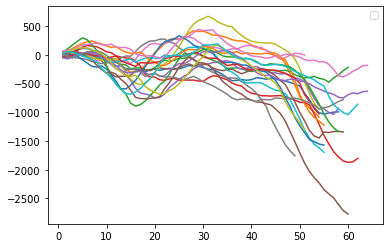

In [8]:
# Printing profit increments
for i in range(len(profit_tracker_list)):
    plt.plot(np.linspace(1,len(profit_tracker_list[i]),len(profit_tracker_list[i])),profit_tracker_list[i])
    plt.legend()

### **Evaluate the model and agent**

In [9]:
import sys
from keras.models import load_model

#if len(sys.argv) != 3:
#    print ("Usage: python evaluate.py [stock] [model]")
#    exit()

# Fill the information when prompted: 
#stock_name = input("Enter Stock_name")
#model_name = input("Enter Model_name")

stock_name = "GSPC_Evaluation_Dataset"
model_name = "model_ep3"

model = load_model(model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
profit_tracker_list = []
profit_tracker = []

for t in range(l):
    action = agent.act(state)

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        agent.inventory.append(data[t])
        print ("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        profit_tracker.append(total_profit)
        print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        profit_tracker_list.append(profit_tracker)
        print ("--------------------------------")
        print (stock_name + " Total Profit: " + formatPrice(total_profit))
        print ("--------------------------------")

--------------------------------
GSPC_Evaluation_Dataset Total Profit: $0.00
--------------------------------


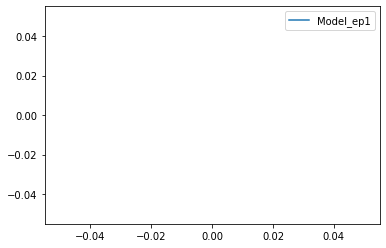

In [10]:
# Printing profit increments
for i in range(len(profit_tracker_list)):
    model_name = "Model_ep"+ str(i+1)
    plt.plot(np.linspace(1,len(profit_tracker_list[i]),len(profit_tracker_list[i])),profit_tracker_list[i], label=model_name)
    plt.legend()